In [1]:
#CASO 1: Predicción de la demanda de prdouctos de una empresa, por meses
import pyodbc
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pylab as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

plt.rcParams['figure.figsize' ] = (16, 9)
plt.style.use('fast')


In [2]:
server = 'US3RN4M3'
database = 'demo_prediccion'

In [3]:
#Sql server config
sql_server=f"""
DRIVER={{ODBC Driver 17 for SQL Server}};
Server={server};
database={database};
Trusted_connection=yes;
"""

In [ ]:
query = """
DECLARE @cols AS NVARCHAR(MAX)
DECLARE @query AS NVARCHAR(MAX)

SET @cols = STUFF((SELECT ', SUM(CASE WHEN [P].[id] = ' + CONVERT(NVARCHAR(10), [SUB]. [id]) + ' THEN [H].[cantidad] ELSE 0 END) AS [' + [SUB].[producto] + ']'
FROM (
SELECT TOP 5
[H].[id_DimProducto] AS id,
[P].[producto] AS producto
FROM [demo_prediccion].[dbo].[hechos] AS [H]
INNER JOIN [demo_prediccion].[dbo].[Dim_productos] AS [P] ON [P].[id] = [H].[id_DimProducto]
GROUP BY [H].[id_DimProducto], [P].[producto]
ORDER BY SUM([H].[cantidad]) DESC, [H].[id_DimProducto] ASC
) AS SUB
FOR XML PATH(''), TYPE).value('.', 'NVARCHAR(MAX)'),1,2,'')

SET @query = '
SELECT
SUBSTRING(CAST([F].[fecha] AS VARCHAR(256)), 0, 8) AS fecha, ' + @cols + '
FROM
[demo_prediccion].[dbo].[hechos] AS [H]
INNER JOIN [demo_prediccion].[dbo].[Dim_fechas] AS [F] ON [F].[id] = [H].[id_DimFechas]
INNER JOIN [demo_prediccion].[dbo].[Dim_productos] AS [P] ON [P].[id] = [H].[id_DimProducto]
GROUP BY
SUBSTRING(CAST([F].[fecha] AS VARCHAR(256)), 0, 8)
ORDER BY
SUBSTRING(CAST([F].[fecha] AS VARCHAR(256)), 0, 8)'

EXEC(@query)
"""


# query = """
# SELECT
# [F]. [Fecha] AS fecha,
# SUM([H]. [cantidad]) AS cantidad
# FROM
# [demo_prediccion]. [dbo]. [hechos] AS [H]
# INNER JOIN [demo_prediccion]. [dbo]. [Dim_fechas] AS [f] ON [H].[id_DimFechas] = [F].[id]
# GROUP BY [F].[Fecha]
# """

In [5]:
#Configuración para el entrenamiento (hace referencia a dias)
PASOS = 12

In [6]:
#Opcion 1: Permitir que pueda ser modificada la sentencia, y mantenrr el try para evitar de que
# el programa se rompa

def get_sqlconnection(config_sqlServer):
    status = "inicializando...."
    try: 
        connection = pyodbc.connect(str(config_sqlServer))
        status = "Conexion establecida satisfactoriamente"
    except Exception as e:
        status = "Error al establecer la conexión:"+e
    print(status)
    return connection


In [7]:
def set_index_datetime(data):
    if str(type(data) == "<class 'pandas.core.frame.DataFrame'>"):
        # data.sort_values('fecha', inplace=True)
        for column in data.columns: 
            try: 
                pd.to_datetime(data[column])
                data.set_index(column,inplace=True)
                return data
            except Exception as e:  
                pass
    else: 
        return 0

In [8]:
def series_to_supervised(data, n_in=1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var&d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
def create_x_y_train(data):
    values = data.values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values= values.reshape(-1, 1)
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    values = reframed.values
    n_train_days = int(len(data)) - (30+PASOS)
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]
    x_train, y_train = train[:, :- 1], train[:, -1]
    x_val, y_val = test[:, :- 1], test[:, -1]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
    return x_train, y_train, x_val, y_val, scaler, values

In [10]:
def crear_modeloFF():
    model = Sequential()
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error', optimizer='Adam',metrics=['mse' ])
    model.summary()
    return model

In [11]:
def entrenar_modelo(x_train, y_train, x_val, y_val, scaler, values, data, model) :
    EPOCHS = 100
    model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val), batch_size=PASOS)
    model.predict(x_val)
    ultimosDias = data[data.index[int(len(data)*0.70)]:]
    values = ultimosDias.values
    values = values.astype('float32' )
    values = values.reshape(-1, 1)
    scaled = values
    reframed = series_to_supervised(scaled, PASOS, 1)
    reframed.drop(reframed.columns[[12]], axis=1, inplace=True)
    values = ultimosDias.values
    values = values.astype('float32' )
    values = values.reshape(-1, 1)
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    reframed.drop(reframed.columns[[12]], axis=1, inplace=True)
    values = reframed.values
    x_test = values[len(values)-1:, :]
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]) )
    return model, x_test

In [12]:
def agregarNuevoValor(x_test, nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test. shape[2]-1] = nuevoValor
    return x_test

In [13]:
def eliminar_anomalias(dtaframe):
    dataFrame_anomalias = dtaframe.copy()
    modeloIsolation = IsolationForest(contamination=0.05)
    modeloIsolation.fit(dataFrame_anomalias)
    anomalias = modeloIsolation.predict(dataFrame_anomalias)
    dtaframe['anomalias' ] = anomalias
    dataFrameSinAnomalias = dtaframe[dtaframe['anomalias' ] != -1]
    dataFrameSinAnomalias = dataFrameSinAnomalias.drop('anomalias', axis=1)
    return dataFrameSinAnomalias

Conexion establecida satisfactoriamente


C:\Users\JoCel\AppData\Local\Temp\ipykernel_4248\2900960394.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  datos = pd.read_sql_query(query, cursor)


2021-01-01 00:00:00
[datetime.datetime(2021, 1, 2, 0, 0), datetime.datetime(2021, 1, 3, 0, 0), datetime.datetime(2021, 1, 4, 0, 0), datetime.datetime(2021, 1, 5, 0, 0), datetime.datetime(2021, 1, 6, 0, 0), datetime.datetime(2021, 1, 7, 0, 0), datetime.datetime(2021, 1, 8, 0, 0), datetime.datetime(2021, 1, 9, 0, 0), datetime.datetime(2021, 1, 10, 0, 0), datetime.datetime(2021, 1, 11, 0, 0), datetime.datetime(2021, 1, 12, 0, 0), datetime.datetime(2021, 1, 13, 0, 0)]


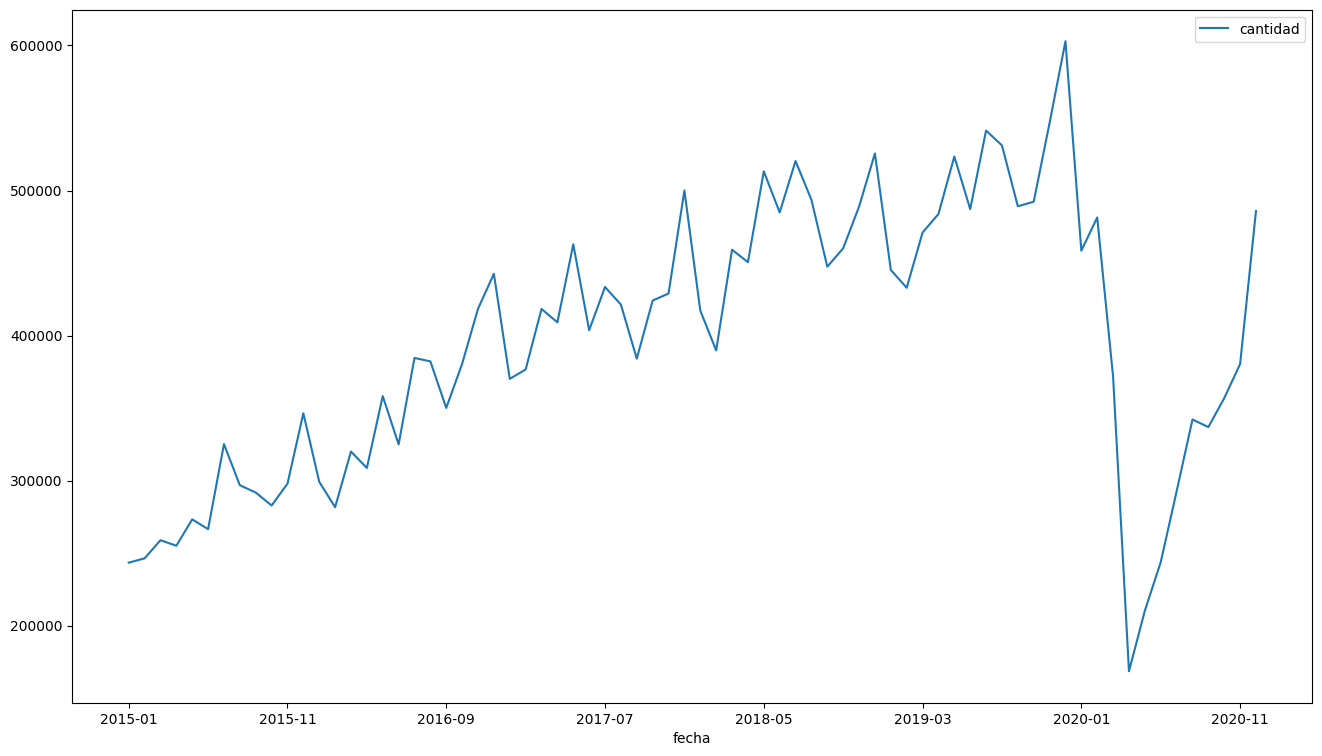

In [14]:

#El Core del sistema
with get_sqlconnection(sql_server) as cursor:
    datos = pd.read_sql_query(query, cursor)
    datos = set_index_datetime(datos)
    datos.plot()

    # Predicción de acuerdo a la oultima fecha registrada que fue en el 2020-12-31
    last_day = datetime.strptime(datos.index.max(), '%Y-%m' ) + relativedelta(months=1)
    print(last_day)

    # Predicción que se hará de acierdo a los pasos que se han definido 
    future_days = [last_day + relativedelta(months=i) for i in range(PASOS)]
    future_days = [last_day + relativedelta(days=i) for i in range(1, PASOS+1)]
    print(future_days)

    # Reesctructuramos los datos que se han obtenido, tomando solo los ultimos 10 digitos
    future_days = [str(i)[:10] for i in future_days]
    for i in range(len(future_days)):
        future_days[i] = str(future_days[i])[:7]
        # future_days[i] = str(future_days[i])[:10]
    # print(future_days)

    #Cremos un arreglo para poder tomar todas las fechas
    #Que servirá para predecir fechas futuras
    future_data = pd.DataFrame(future_days)
    future_data.columns = ['fecha']

In [15]:
    

    #Creamos un modelo de datos
    model = crear_modeloFF()
    data = []
    print(datos.columns.values)
    for column in datos.columns:
        data = datos.filter([column])
        data.set_index(datos.index, inplace=True)
        data = eliminar_anomalias(data)
        x_train, y_train, x_val, y_val, scaler, values = create_x_y_train(data)
        model, x_test = entrenar_modelo(x_train, y_train, x_val, y_val, scaler, values, data, model)
        #Guardar el modelo
        
        results = []
        for i in range(PASOS):
            parcial = model.predict(x_test)
            results.append(parcial[0])
            x_test = agregarNuevoValor(x_test, parcial[0])
        adimen = [x for x in results]
        inverted = scaler.inverse_transform(adimen)
        y_pred = pd.DataFrame(inverted.astype(int))
        future_data[column]= inverted.astype(int)
    future_data = set_index_datetime(future_data)



c:\Residencia_proyecto\PRONOSTICO\PRONOSTICO_DE_INVENTARIOS\4.- Recursos\experimentales_prediccion\prediccion\envprediccion\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1, 12)          │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169 (676.00 B)

 Trainable params: 169 (676.00 B)

 Non-trainable params: 0 (0.00 B)

['cantidad']
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2329 - mse: 0.0918 - val_loss: 0.3034 - val_mse: 0.1698
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2626 - mse: 0.1144 - val_loss: 0.3064 - val_mse: 0.1705
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2388 - mse: 0.0925 - val_loss: 0.3057 - val_mse: 0.1692
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2561 - mse: 0.1064 - val_loss: 0.3045 - val_mse: 0.1680
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2369 - mse: 0.0960 - val_loss: 0.3026 - val_mse: 0.1667
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2315 - mse: 0.0876 - val_loss: 0.3029 - val_mse: 0.1665
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2266 - mse: 0.0895 - val_loss: 0.3046 - val_mse: 0.1671
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2318 - mse: 0.0931 - val_loss: 0.3071 - val_mse: 0.1682
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0

C:\Users\JoCel\AppData\Local\Temp\ipykernel_4248\2297903707.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_test[0][0][x_test. shape[2]-1] = nuevoValor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [16]:
# print(future_data)
# future_data.plot()

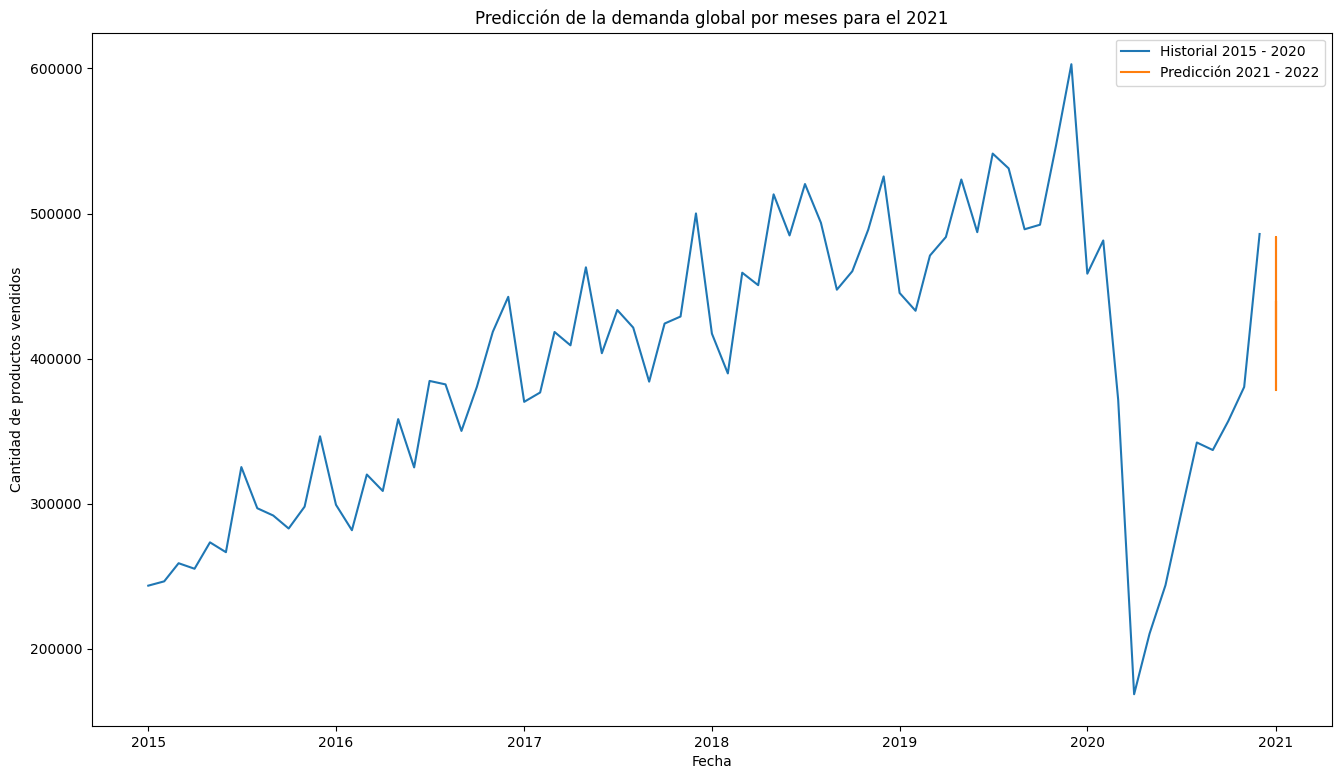

,cantidad
fecha,
2021-01-01,378759
2021-01-01,404488
2021-01-01,441917
2021-01-01,477016
2021-01-01,484011
2021-01-01,453568
2021-01-01,419852
2021-01-01,427000
2021-01-01,439677


In [17]:
    datos.index = pd.to_datetime(datos.index)
    future_data.index = pd.to_datetime(future_data.index)

    #Graficar los dataframes
    plt.plot(datos.index, datos['cantidad'],label='Historial 2015 - 2020')
    plt.plot(future_data.index, future_data['cantidad'],label='Predicción 2021 - 2022')

    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de productos vendidos')
    plt.title('Predicción de la demanda global por meses para el 2021')


    plt.legend()
    plt.show()
    future_data